In [1]:
from tree_sitter import Language, Parser

Language.build_library(
    './build/my-ebnf2.so',  
    ['./tree-sitter-ebnf'] 
)
MY_LANGUAGE = Language('./build/my-ebnf3.so', 'EBNF')

parser = Parser()
parser.set_language(MY_LANGUAGE)
source_code = b"""
externals ::= { line_comment block_comment /\\s/ };
"""

tree = parser.parse(source_code)

root_node = tree.root_node

print(root_node.sexp())


(source_file (ERROR (lhs (identifier)) (ERROR (UNEXPECTED '{')) (statements (identifier)) (statementsNoSelection (identifier)) (ERROR (UNEXPECTED '/')) (quantifierBase (identifier)) (UNEXPECTED '/')))


# Create RRD

In [2]:
from RRD.railroad import Diagram, Choice, Sequence, OptionalSequence, HorizontalChoice, OneOrMore, ZeroOrMore, Optional
from IPython.display import SVG, display
import io

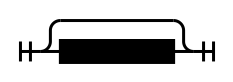

In [3]:
d = Diagram(OptionalSequence('a','b', 'c'))
d = Diagram(Choice(1,'a','b', 'c'))
d = Diagram(ZeroOrMore('a'))
d = Diagram(Optional('a\nb\nc\ng\ns\ns'))

outputStream = io.StringIO()
d.writeStandalone(outputStream.write)
display(SVG(data=outputStream.getvalue()))

In [4]:

def visit(node, diagrams = {}):
    match(node.type):
        case 'source_file':
            for i in range(len(node.children)):
                diagrams =  visit(node.children[i], diagrams)
            return diagrams
        case 'rule':
            name = node.children[0].text.decode()
            diagrams[name] = Diagram(visit(node.children[2]))
            return diagrams
        case 'rhs':
            return visit(node.children[0])
        case 'sequence':
            blocks = []
            for child in node.children:
                blocks.append(visit(child))
            return Sequence(*blocks)
        case 'statements':
            return visit(node.children[0])
        case 'parenthesizedStatement':
            return visit(node.children[1])
        case 'quantifiedStatement':
            return visit(node.children[0])
        case 'selectionStatement':
            blocks = []
            for child in node.children:
                if child.type == 'sequenceNoSelection':
                    blocks.append(visit(child))
            return Choice(len(blocks)//2, *blocks)
        case 'sequenceNoSelection':
            blocks = []
            for child in node.children:
                blocks.append(visit(child))
            return Sequence(*blocks)
        case 'statementsNoSelection':
            return visit(node.children[0])
        case 'optional':
            return Optional(visit(node.children[0]))
        case 'oneOrMore':
            return OneOrMore(visit(node.children[0]))
        case 'zeroOrMore':
            return ZeroOrMore(visit(node.children[0]))
        case 'quantifierBase':
            return visit(node.children[0])
        case 'identifier':
            return node.text.decode() #+ "\nCount: 0\nMetric: 0"
        case _:
            if len(node.children) > 0:
                print('Not implemented: ' + str(node.type))
                for i in range(len(node.children)):
                    return visit(node.children[i])

Diagram(Sequence(Terminal("Name"), Choice(1, Skip(), OneOrMore(Sequence(Terminal("Name")), repeat=Skip()))))


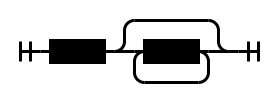

In [13]:
# Parse some code
# source_code = b"""
# binary_statement ::= statement operator statement;
# unary_statement ::= operator statement;
# function_definition ::= def function_name ( (type? arg)*? );
# """

# Not implemented literal
source_code = b"""
  namelist         ::= Name ( Name)*;

"""
node = parser.parse(source_code).root_node
diagrams = visit(node)
d = diagrams['namelist']
print(d)
outputStream = io.StringIO()
d.writeStandalone(outputStream.write)
display(SVG(data=outputStream.getvalue()))



SVG files saved in svg_output directory:
1. Original SVG: 8e53c84b_original.svg
2. Final SVG: 8e53c84b_final.svg


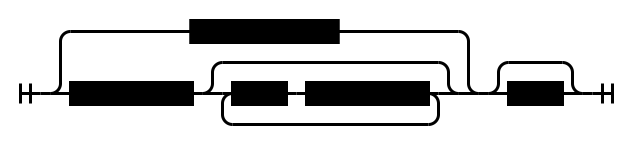


SVG files saved in svg_output directory:
1. Original SVG: 0d466301_original.svg
2. Final SVG: 0d466301_final.svg


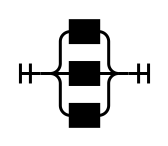

In [6]:
from ebnf_visualizer import visualize_ebnf, reset_global_counts

reset_global_counts()

source_code = b"""
SourceFile          ::= (CompilationUnit | TemplateStat (semi TemplateStat)*) semi?;
a ::= b | c | c;
"""

node = parser.parse(source_code).root_node
diagrams = visit(node)
d = diagrams['SourceFile']

display(visualize_ebnf(d))
d2 = diagrams['a']

display(visualize_ebnf(d2))

Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: ERROR
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: ERROR
Not implemented: ERROR
Not implemented: ERROR
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
Not implemented: terminal
Not implemented: terminal
Not implemented: ERROR
Not implemented: ERROR
Not implemented: terminal
Not implemented: terminal
Not implemented: terminal
Not implemented: terminal
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: terminal
Not implemented: terminal
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: terminal
Not implemented: ERROR
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not im

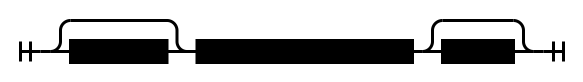

Not implemented: ERROR
Not implemented: terminal
Not implemented: terminal
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
Not implemented: terminal
Not implemented: terminal
Not implemented: terminal
Not implemented: terminal
Not implemented: ERROR
Not implemented: lhs
Not implemented: terminal
Not implemented: terminal
Not implemented: terminal
Not implemented: terminal
Not implemented: terminal
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: terminal
Not implemented: terminal
Not implemented: ERROR
Not implemented: ERROR
Not implemented: ERROR
Not implemented: ERROR
Not implemented: terminal
Not implemented: ERROR
Not implemented: ERROR
Not implemented: lhs
Not implemented: terminal
Not implemented: terminal
Not 

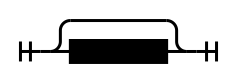

Not implemented: terminal
Not implemented: terminal
Not implemented: terminal
Not implemented: terminal
Not implemented: ERROR
Not implemented: lhs


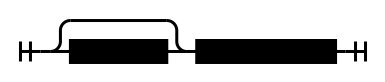

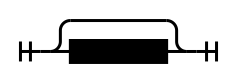

Not implemented: ERROR
Not implemented: lhs
Not implemented: terminal
Not implemented: terminal
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
Not implemented: ERROR
Not implemented: lhs
In total 173 rules, and 169 failed, saved to ebnf_failed_rules.csv


In [12]:
import io
import re
import csv
from IPython.display import SVG, display

report = []

with open("tree-sitter-ebnf-generator/examples/java/testEBNF.ebnf", "r", encoding="utf-8") as f:
    lines = f.readlines()

for line_num, line in enumerate(lines):
    line = line.strip()
    
    if not line or '::=' not in line:
        continue

    try:
        left, right = map(str.strip, line.split("::=", 1))

        source_code = (left + ' ::= ' + right + ';').encode("utf-8")
        node = parser.parse(source_code).root_node
        diagrams = visit(node)

        d = diagrams[left]

        outputStream = io.StringIO()
        d.writeStandalone(outputStream.write)
        display(SVG(data=outputStream.getvalue()))

        report.append({
            "line": line_num + 1,
            "rule": line,
            "status": "Success",
            "error": ""
        })

    except Exception as e:
        report.append({
            "line": line_num + 1,
            "rule": line,
            "status": "Failed",
            "error": str(e)
        })

failed = [r for r in report if r['status'] == 'Failed']

with open("ebnf_failed_rules_java.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["line", "rule", "error"])
    writer.writeheader()
    for row in failed:
        writer.writerow({"line": row["line"], "rule": row["rule"], "error": row["error"]})

print(f"In total {len(report)} rules, and {len(failed)} failed, saved to ebnf_failed_rules.csv")
